In [ ]:
!nvidia-smi

In [ ]:
!mkdir -p .kaggle
!cp "./kaggle.json" .kaggle/
!chmod 600 .kaggle/kaggle.json
!cp -r .kaggle /root

!kaggle -v

In [ ]:
# competition data
#!kaggle competitions download -c feedback-prize-english-language-learning
#!unzip feedback-prize-english-language-learning.zip
#!rm -rf feedback-prize-english-language-learning.zip
#!mkdir -p competition_data
#!mv sample_submission.csv test.csv train.csv competition_data/
!echo "### competition data ###"
!ls /content/competition_data/
!echo

# pseudo labels
#!mkdir -p fb3-distillation-data-final
#!kaggle kernels output takamichitoda/fb3-make-avg-distillation-pseudo -p ./fb3-distillation-data-final
!echo "### pseudo data ###"
!ls ./fb3-distillation-data-final
!echo

In [ ]:
!pip install iterative-stratification==0.1.7

In [1]:
import gc
import json
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from torch.utils.checkpoint import checkpoint

import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_cosine_schedule_with_warmup

is_gpu = torch.cuda.is_available()
device = torch.device('cuda' if is_gpu else 'cpu')
scaler = torch.cuda.amp.GradScaler(enabled=is_gpu)

%env TOKENIZERS_PARALLELISM=true
print(device)
print(f"transformers.__version__: {transformers.__version__}")

env: TOKENIZERS_PARALLELISM=true
cuda
transformers.__version__: 4.20.1


In [2]:
class CFG:
    EXP_NUM = 15
    MEMO = "final"

    INPUT = "/home/jupyter/competition_data"
    OUTPUT = f"/home/jupyter/output/distribution/"
    SEED = 0
    N_FOLD = 4
    TARGETS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    
    MODEL_NAME = "microsoft/deberta-v3-xsmall"
    TOKENIZER = None
    MAX_LEN = 512
    GRAD_CHECKPOINT = False
    
    N_EPOCH = 16
    N_WORKER = 4
    ENCODER_LR = 1e-4
    DECODER_LR = 5e-3

    EPS = 1e-6
    BETAS = (0.9, 0.999)
    WEIGHT_DECAY = 0.1
    N_WARMUP = 0
    N_CYCLES = 0.5
    
    BS = 64
    ACCUMLATION = 1
    
    GRAD_NORM = 0.1
    
    MASK_RATIO = 0.1
    
    SKIP_FOLDS = [None]
    LOCAL_SEED = 0

!mkdir -p {CFG.OUTPUT}
!kaggle datasets init -p {CFG.OUTPUT}

with open(f'{CFG.OUTPUT}/dataset-metadata.json', 'r') as f:
    d = json.load(f)
t = f'FB3 distribution last'

d['title'] = t
d['id'] = f'takamichitoda/'+ t.replace(' ', '-')
print(d)
with open(f'{CFG.OUTPUT}/dataset-metadata.json', 'w') as f:
    json.dump(d, f)
del d

s = {k:v for k, v in vars(CFG).items() if "__" != k[:2]}
with open(f'{CFG.OUTPUT}/setting.json', 'w') as f:
    json.dump(s, f)
del s

!rm -rf {CFG.OUTPUT}/tokenizer*
TOKENIZER = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)
TOKENIZER.save_pretrained(CFG.OUTPUT+'tokenizer/')
CFG.TOKENIZER = TOKENIZER
del TOKENIZER
!zip -r tokenizer.zip {CFG.OUTPUT}/tokenizer
!mv tokenizer.zip {CFG.OUTPUT}

Data package template written to: /home/jupyter/output/distribution/dataset-metadata.json
{'title': 'FB3 distribution last', 'id': 'takamichitoda/FB3-distribution-last', 'licenses': [{'name': 'CC0-1.0'}]}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  adding: home/jupyter/output/distribution//tokenizer/ (stored 0%)
  adding: home/jupyter/output/distribution//tokenizer/special_tokens_map.json (deflated 54%)
  adding: home/jupyter/output/distribution//tokenizer/added_tokens.json (stored 0%)
  adding: home/jupyter/output/distribution//tokenizer/tokenizer.json (deflated 77%)
  adding: home/jupyter/output/distribution//tokenizer/tokenizer_config.json (deflated 45%)
  adding: home/jupyter/output/distribution//tokenizer/spm.model (deflated 50%)


In [3]:
org_train_df = pd.read_csv(f"{CFG.INPUT}/train.csv")

cv = MultilabelStratifiedKFold(n_splits=CFG.N_FOLD, shuffle=True, random_state=CFG.SEED)
for n, (train_index, valid_index) in enumerate(cv.split(org_train_df, org_train_df[CFG.TARGETS])):
    org_train_df.loc[valid_index, 'fold'] = int(n)
org_train_df['fold'] = org_train_df['fold'].astype(int)

display(org_train_df.head())

text_for_distillation_df = pd.read_csv('fb3-distillation-data-final/AVG_pseudo.csv')

display(text_for_distillation_df.head())

(org_train_df['fold'] == text_for_distillation_df.query('origin')['fold']).mean()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,fold
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,2
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,3
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,0
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,2


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,fold,origin
0,0016926B079C,I think that students would benefit from learn...,3.018248,2.975119,3.121308,3.170475,3.175702,2.880757,2,True
1,0022683E9EA5,When a problem is a change you have to let it ...,2.706631,2.599061,2.869723,2.708271,2.475758,2.625469,3,True
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",2.832288,2.960374,3.035029,2.946630,2.983717,3.079813,0,True
3,003885A45F42,The best time in life is when you become yours...,3.739573,3.700710,3.771889,3.764411,3.721735,3.855008,0,True
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.491964,2.439298,2.848604,2.701830,2.642546,2.390833,2,True


1.0

In [4]:
all_pseudo_vecs = np.load("fb3-distillation-data-final/all_pseudo.npy")
all_pseudo_vecs.shape

(40, 7984, 6)

In [5]:
all_pseudo_vecs_fold = np.stack([all_pseudo_vecs[i*4:i*4+4, :, :] for i in range(10)])
all_pseudo_vecs_fold.shape

(10, 4, 7984, 6)

In [6]:
np.median(all_pseudo_vecs_fold.mean(1), 0)

array([[3.0354385, 2.9816506, 3.130321 , 3.1700034, 3.1622906, 2.8736572],
       [2.664759 , 2.5898054, 2.8661423, 2.7049441, 2.4630837, 2.6250384],
       [2.8375874, 2.9681032, 3.0402222, 2.9363437, 2.9911904, 3.106997 ],
       ...,
       [3.42127  , 3.4127638, 3.5362985, 3.555582 , 3.79319  , 3.5025253],
       [3.8772469, 3.7908058, 3.814385 , 3.8354151, 4.017723 , 3.8829298],
       [4.059508 , 4.0865126, 4.23125  , 4.257974 , 4.4012203, 4.069358 ]],
      dtype=float32)

In [7]:
MASK_ID = 128000
def masking(inputs):
    is_special_token = (np.array(inputs["input_ids"]) == 1).astype(int) + (np.array(inputs["input_ids"]) == 2).astype(int)
    mask = np.array([random.random() < CFG.MASK_RATIO for _ in range(CFG.MAX_LEN)])
    mask = mask * np.array(inputs["attention_mask"]) * (1 - is_special_token)
    masking_ids = np.where(mask != 0, MASK_ID, inputs["input_ids"])
    return masking_ids

In [8]:
class FB3Dataset(Dataset):
    def __init__(self, df, train=False):
        self.texts = df['full_text'].values
        self.labels = df[CFG.TARGETS].values
        self.train = train

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = CFG.TOKENIZER.encode_plus(
            self.texts[item], 
            return_tensors=None, 
            add_special_tokens=True, 
            max_length=CFG.MAX_LEN,
            pad_to_max_length=True,
            truncation=True
        )
        #if self.train:
        #    inputs["input_ids"] = masking(inputs)

        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long) 
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

In [9]:
class FB3Dataset_v2(Dataset):
    def __init__(self, df, train=False):
        self.texts = df['full_text'].values
        self.labels = df[CFG.TARGETS].values
        self.train = train

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        if self.train:
            inputs = CFG.TOKENIZER.encode_plus(
                self.texts[item], 
                return_tensors=None, 
                add_special_tokens = False,
            )

            if len(inputs['input_ids']) > CFG.MAX_LEN:
                l = CFG.MAX_LEN - 2
                start_i = random.sample(list(range(len(inputs['input_ids']) - l)), 1)
                start_i = start_i[0]
                inputs['input_ids'] = [1] + inputs['input_ids'][start_i:start_i+l] + [2]
                inputs['attention_mask'] = [1] + inputs['attention_mask'][start_i:start_i+l] + [1]
                inputs['token_type_ids'] = [0] + inputs['token_type_ids'][start_i:start_i+l] + [0]

            pad = [0] * (CFG.MAX_LEN - len(inputs['input_ids']))
            inputs['input_ids'] += pad
            inputs['attention_mask'] += pad
            inputs['token_type_ids'] += pad
        else:
            inputs = CFG.TOKENIZER.encode_plus(
                self.texts[item], 
                return_tensors=None, 
                add_special_tokens=True, 
                max_length=CFG.MAX_LEN,
                pad_to_max_length=True,
                truncation=True
            )

        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long) 
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [10]:
class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, all_hidden_states):
        all_layer_embedding = all_hidden_states[self.layer_start:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return weighted_average

class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class CustomModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()

        self.config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
        self.config.hidden_dropout = 0.
        self.config.hidden_dropout_prob = 0.
        self.config.attention_dropout = 0.
        self.config.attention_probs_dropout_prob = 0.
        self.config.num_hidden_layers = 4

        self.model = AutoModel.from_pretrained(model_name, config=self.config)

        if CFG.GRAD_CHECKPOINT:
            self.model.gradient_checkpointing_enable()
            
        
        layer_start = self.config.num_hidden_layers
        self.layer_pool = WeightedLayerPooling(
            self.config.num_hidden_layers, 
            layer_start=layer_start, layer_weights=None
        )
        #self.lstm = nn.LSTM(self.config.hidden_size, self.config.hidden_size, batch_first=True)
        
        self.pool = MeanPooling()
        self.fc = nn.Sequential(
            nn.Linear(self.config.hidden_size, self.config.hidden_size),
            nn.ReLU(),
            nn.Linear(self.config.hidden_size, 6),
        )
        self._init_weights(self.fc)
        #self.fc1 = nn.Sequential(
        #    nn.Linear(self.config.hidden_size, self.config.hidden_size),
        #    nn.ReLU(),
        #    nn.Linear(self.config.hidden_size, 6),
        #)
        #self._init_weights(self.fc1)
        #self.fc2 = nn.Sequential(
        #    nn.Linear(self.config.hidden_size, self.config.hidden_size),
        #    nn.ReLU(),
        #    nn.Linear(self.config.hidden_size, 6),
        #)
        #self._init_weights(self.fc2)
        
        # reinit_layers
        reinit_layer = 1
        if reinit_layer > 0:
            for layer in self.model.encoder.layer[-reinit_layer:]:
                for module in layer.modules():
                    if isinstance(module, nn.Linear):
                        module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
                        if module.bias is not None:
                            module.bias.data.zero_()
                    elif isinstance(module, nn.Embedding):
                        module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
                        if module.padding_idx is not None:
                            module.weight.data[module.padding_idx].zero_()
                    elif isinstance(module, nn.LayerNorm):
                        module.bias.data.zero_()
                        module.weight.data.fill_(1.0)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, inputs):
        outputs = self.model(**inputs)

        pooling_embeddings = outputs[0]
        #all_hidden_states = torch.stack(outputs[1])
        #pooling_embeddings = self.layer_pool(all_hidden_states)
        
        #out, _ = self.lstm(pooling_embeddings, None)
        #pooling_embeddings = out #.swapaxes(1, 2)

        feature = self.pool(pooling_embeddings, inputs['attention_mask'])
        #feature = pooling_embeddings[:, 0, :]
        
        output = self.fc(feature)
        return output
        #output1 = self.fc1(feature)
        #output2 = self.fc2(feature)
        #return output1, output2

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores


def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [12]:
"""
def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters
"""
def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    no_decay = ["bias", "LayerNorm.weight"]
    group1=['layer.0.']
    group2=['layer.1.']    
    group3=['layer.2.','layer.3.']
    group_all=['layer.0.','layer.1.','layer.2.','layer.3.']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay) and not any(nd in n for nd in group_all)],'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay) and any(nd in n for nd in group1)],'weight_decay': weight_decay, 'lr': encoder_lr/4.0},
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay) and any(nd in n for nd in group2)],'weight_decay': weight_decay, 'lr': encoder_lr/2.0},
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay) and any(nd in n for nd in group3)],'weight_decay': weight_decay, 'lr': encoder_lr},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay) and not any(nd in n for nd in group_all)],'weight_decay': 0.0},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay) and any(nd in n for nd in group1)],'weight_decay': 0.0, 'lr': encoder_lr/4.0},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay) and any(nd in n for nd in group2)],'weight_decay': 0.0, 'lr': encoder_lr/2.0},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay) and any(nd in n for nd in group3)],'weight_decay': 0.0, 'lr': encoder_lr},
        {'params': [p for n, p in model.named_parameters() if "model" not in n], 'lr': decoder_lr, "weight_decay": 0.0},
    ]
    return optimizer_grouped_parameters

In [13]:
def train_fn(epoch, train_loader, student, criterion, optimizer, scheduler):
    student.train()

    losses = AverageMeter()
    global_step = 0
    for step, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        
        
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=is_gpu):
            y_preds = student(inputs)
            loss = criterion(y_preds, labels)
            #y_preds1, y_preds2 = student(inputs)
            #loss1 = criterion(y_preds1, torch.ceil(labels))
            #loss2 = criterion(y_preds2, torch.floor(labels))
            #loss = loss1 + loss2


        if CFG.ACCUMLATION > 1:
            loss = loss / CFG.ACCUMLATION
            
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(student.parameters(), CFG.GRAD_NORM)
        
        if (step + 1) % CFG.ACCUMLATION == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            scheduler.step()
                
    return losses.avg

def valid_fn(valid_loader, model, criterion):
    losses = AverageMeter()
    model.eval()
    preds = []
    for step, (inputs, labels) in enumerate(valid_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
            #y_preds1, y_preds2 = model(inputs)
            #y_preds = (y_preds1 + y_preds2) / 2
            loss = criterion(y_preds, labels)
            
        if CFG.ACCUMLATION > 1:
            loss = loss / CFG.ACCUMLATION
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())

    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [14]:
from torch.optim.swa_utils import AveragedModel, SWALR

def swa_fn(epoch, train_loader, model, swa_model, criterion, optimizer, scheduler):
    model.train()

    losses = AverageMeter()
    global_step = 0
    for step, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=is_gpu):
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            
        if CFG.ACCUMLATION > 1:
            loss = loss / CFG.ACCUMLATION
            
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()


        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.GRAD_NORM)
        
        if (step + 1) % CFG.ACCUMLATION == 0:
            scaler.step(optimizer)
            scaler.update()
            swa_model.update_parameters(model)
            
            optimizer.zero_grad()
            global_step += 1
            scheduler.step()
                
    return losses.avg

In [15]:
class CustomLoss(nn.Module):
    def __init__(self, eps, mask):
        super(CustomLoss, self).__init__()
        self.eps = eps
        self.mask = mask

    def forward(self, outputs, targets):
        loss = nn.MSELoss(reduction='none')(outputs, targets)

        if self.mask is None:
            loss = torch.mean(torch.clamp(loss - self.eps**2, min=0))
        else:
            loss = torch.mean(torch.clamp(loss - self.eps**2, min=0, max=self.mask**2))

        return loss

In [16]:
from torch.optim import Optimizer

class PriorWD(Optimizer):
    def __init__(self, optim, use_prior_wd=False, exclude_last_group=True):
        super(PriorWD, self).__init__(optim.param_groups, optim.defaults)
        self.param_groups = optim.param_groups
        self.optim = optim
        self.use_prior_wd = use_prior_wd
        self.exclude_last_group = exclude_last_group
        self.weight_decay_by_group = []
        for i, group in enumerate(self.param_groups):
            self.weight_decay_by_group.append(group["weight_decay"])
            group["weight_decay"] = 0

        self.prior_params = {}
        for i, group in enumerate(self.param_groups):
            for p in group["params"]:
                self.prior_params[id(p)] = p.detach().clone()

    def step(self, closure=None):
        if self.use_prior_wd:
            for i, group in enumerate(self.param_groups):
                for p in group["params"]:
                    if self.exclude_last_group and i == len(self.param_groups):
                        p.data.add_(-group["lr"] * self.weight_decay_by_group[i], p.data)
                    else:
                        p.data.add_(
                            -group["lr"] * self.weight_decay_by_group[i], p.data - self.prior_params[id(p)],
                        )
        loss = self.optim.step(closure)

        return loss

    def compute_distance_to_prior(self, param):
        assert id(param) in self.prior_params, "parameter not in PriorWD optimizer"
        return (param.data - self.prior_params[id(param)]).pow(2).sum().sqrt()

In [21]:
def train_loop(fold, seed):
    if fold == "ALL":
        text_for_distillation_df[CFG.TARGETS] = all_pseudo_vecs_fold.mean(0).mean(0)
        valid_df = org_train_df
        train_df = text_for_distillation_df
    else:
        text_for_distillation_df[CFG.TARGETS] = all_pseudo_vecs_fold[:, fold, :, :].mean(0)
        #text_for_distillation_df[CFG.TARGETS] = all_pseudo_vecs_fold[[1,2,3,5,6,8], fold, :, :].mean(0)
        #text_for_distillation_df[CFG.TARGETS] = all_pseudo_vecs_fold[[0,1,2], fold, :, :].mean(0)
        valid_df = org_train_df.query(f"fold=={fold}")
        train_df = text_for_distillation_df.query(f"fold!={fold}")

    valid_labels = valid_df[CFG.TARGETS].values
    train_dataset = FB3Dataset(train_df, train=True)
    valid_dataset = FB3Dataset(valid_df, train=False)
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.BS,
                              shuffle=True,
                              num_workers=CFG.N_WORKER, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.BS,
                              shuffle=False,
                              num_workers=CFG.N_WORKER, pin_memory=True, drop_last=False)

    student = CustomModel(CFG.MODEL_NAME)
    torch.save(student.config, CFG.OUTPUT + 'config.pth')
    student.to(device)

    optimizer_parameters = get_optimizer_params(student,
                                                encoder_lr=CFG.ENCODER_LR, 
                                                decoder_lr=CFG.DECODER_LR,
                                                weight_decay=CFG.WEIGHT_DECAY)

    optimizer = AdamW(optimizer_parameters, lr=CFG.ENCODER_LR, eps=CFG.EPS, betas=CFG.BETAS, correct_bias=True)
    optimizer = PriorWD(optimizer, use_prior_wd=True)

    num_train_steps = int(len(train_dataset) / CFG.BS * CFG.N_EPOCH)
    scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=CFG.N_WARMUP, num_training_steps=num_train_steps, num_cycles=CFG.N_CYCLES
    )
    #criterion = nn.SmoothL1Loss(reduction='mean', beta=1.0)
    #criterion = nn.HuberLoss(reduction='mean', delta=1.0)
    #criterion = svm_loss
    criterion = CustomLoss(eps=0.1, mask=None)

    swa_model = AveragedModel(student)
    swa_scheduler = SWALR(optimizer, swa_lr=1e-6)

    best_score = float("inf")
    best_predictions = None
    results = []
    for epoch in range(CFG.N_EPOCH):
        if epoch == 7:
            mask = 1.5
            print(f'eps=0.0, mask={mask}')
            criterion = CustomLoss(eps=0.0, mask=mask)

        if epoch < 45:
            avg_loss = train_fn(epoch, train_loader, student, criterion, optimizer, scheduler)
            avg_val_loss, predictions = valid_fn(valid_loader, student, criterion)
        else:
            avg_loss = swa_fn(epoch, train_loader, student, swa_model, criterion, optimizer, swa_scheduler)
            avg_val_loss, predictions = valid_fn(valid_loader, swa_model, criterion)

        score, _ = get_score(valid_labels, predictions)
        
        if best_score > score:
            best_score = score
            best_predictions = predictions
            torch.save({'model': student.state_dict(),
                        'predictions': predictions},
                         f"{CFG.OUTPUT}/{CFG.MODEL_NAME.replace('/', '-')}_seed{seed}_fold{fold}_best.pth")
        print(f"[Fold-{fold}] epoch-{epoch}: score={score}")
        results.append((fold, epoch, score, best_score))

        if fold == "ALL" and epoch > 0:
            torch.save({'model': student.state_dict(),
                        'predictions': predictions},
                        f"{CFG.OUTPUT}/{CFG.MODEL_NAME.replace('/', '-')}_seed{seed}_fold{fold}_epoch{epoch}.pth")
        torch.cuda.empty_cache()
        gc.collect()
        
    return best_score, results

In [22]:
def main(seed):
    scores = []
    results_lst = []
    for fold in range(CFG.N_FOLD):
        if fold in CFG.SKIP_FOLDS:
            continue
        seed_everything(seed)
        score, results = train_loop(fold, seed)
        scores.append(score)
        results_lst += results
    print(scores)
    print(sum(scores) / CFG.N_FOLD)

    pd.DataFrame(results_lst, columns=['fold',  'epoch', 'score', 'best_score']).to_csv(f"{CFG.OUTPUT}/result.csv", index=None)

In [23]:
#if __name__ == '__main__':
#    main(CFG.LOCAL_SEED)

Some weights of the model checkpoint at microsoft/deberta-v3-xsmall were not used when initializing DebertaV2Model: ['deberta.encoder.layer.7.intermediate.dense.weight', 'deberta.encoder.layer.6.attention.output.LayerNorm.weight', 'deberta.encoder.layer.6.output.LayerNorm.bias', 'deberta.encoder.layer.5.output.LayerNorm.bias', 'deberta.encoder.layer.11.attention.output.dense.weight', 'deberta.encoder.layer.4.attention.self.query_proj.weight', 'deberta.encoder.layer.7.output.LayerNorm.weight', 'deberta.encoder.layer.8.attention.output.LayerNorm.weight', 'deberta.encoder.layer.4.attention.self.value_proj.bias', 'deberta.encoder.layer.4.output.LayerNorm.bias', 'deberta.encoder.layer.10.intermediate.dense.weight', 'mask_predictions.LayerNorm.bias', 'deberta.encoder.layer.11.attention.self.value_proj.weight', 'deberta.encoder.layer.7.attention.output.LayerNorm.weight', 'deberta.encoder.layer.8.attention.self.value_proj.bias', 'deberta.encoder.layer.11.intermediate.dense.bias', 'deberta.enco

  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-0: score=0.5132259895808844


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-1: score=0.4848833539141923


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-2: score=0.4939199873921862


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-3: score=0.47949929313301914


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-4: score=0.46986867856192305


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-5: score=0.460802145826348


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-6: score=0.45923104084146465
eps=0.0, mask=1.5


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-7: score=0.4684564534171394


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-8: score=0.4568428280442017


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-9: score=0.45839842399443725


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-10: score=0.4468800707690845


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-11: score=0.4481169937280405


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-12: score=0.44458947634972557


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-13: score=0.44607483599008174


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-14: score=0.4418350059457903


  0%|          | 0/124 [00:00<?, ?it/s]

[Fold-ALL] epoch-15: score=0.44192090146740876
0.4418350059457903


,fold,epoch,score,best_score
0,ALL,0,0.513226,0.513226
1,ALL,1,0.484883,0.484883
2,ALL,2,0.493920,0.484883
3,ALL,3,0.479499,0.479499
4,ALL,4,0.469869,0.469869
5,ALL,5,0.460802,0.460802
6,ALL,6,0.459231,0.459231
7,ALL,7,0.468456,0.459231
8,ALL,8,0.456843,0.456843
9,ALL,9,0.458398,0.456843


<AxesSubplot:>

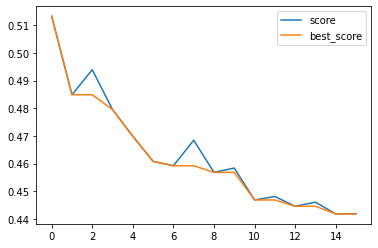

In [24]:
seed_everything(0)
score, results = train_loop("ALL", 0)
print(score)

df = pd.DataFrame(results, columns=['fold',  'epoch', 'score', 'best_score'])
df.columns=['fold',  'epoch', 'score', 'best_score']
df.to_csv(f"{CFG.OUTPUT}/result_all.csv", index=None)
display(df)

df[['score', 'best_score']].plot()

In [25]:
#!kaggle datasets create -p {CFG.OUTPUT}
!kaggle datasets version -p {CFG.OUTPUT} -m 'all tune'

Starting upload for file microsoft-deberta-v3-xsmall_seed0_foldALL_epoch15.pth
100%|████████████████████████████████████████| 216M/216M [00:09<00:00, 23.4MB/s]
Upload successful: microsoft-deberta-v3-xsmall_seed0_foldALL_epoch15.pth (216MB)
Starting upload for file microsoft-deberta-v3-xsmall_seed0_foldALL_epoch3.pth
100%|████████████████████████████████████████| 216M/216M [00:07<00:00, 29.4MB/s]
Upload successful: microsoft-deberta-v3-xsmall_seed0_foldALL_epoch3.pth (216MB)
Starting upload for file config.pth
100%|██████████████████████████████████████| 2.55k/2.55k [00:01<00:00, 1.40kB/s]
Upload successful: config.pth (3KB)
Starting upload for file microsoft-deberta-v3-xsmall_seed0_foldALL_epoch5.pth
100%|████████████████████████████████████████| 216M/216M [00:06<00:00, 32.7MB/s]
Upload successful: microsoft-deberta-v3-xsmall_seed0_foldALL_epoch5.pth (216MB)
Starting upload for file microsoft-deberta-v3-xsmall_seed0_foldALL_epoch11.pth
100%|████████████████████████████████████████| 21

In [ ]:
!rm -rf {CFG.OUTPUT}